# Introduction
 Below is implementation of ControlNet in PyTorch for [denoising diffusion probabilistic models](https://arxiv.org/abs/2006.11239) used on MNIST dataset

First part, 
*  Training and Inference of DDPM on MNIST dataset
Second part,
*  Training and Inference of ControlNet with DDPM on MNIST using canny edges

Current reimplementaton is adopted from theoriginal codebase are found in below repositories-


https://github.com/lllyasviel/ControlNet, 
https://github.com/explainingai-code/VAE-Pytorch#data-preparation, 
https://github.com/explainingai-code/ControlNet-PyTorch, 



# Setting up evironment to run controlnet on Google Colab

In [1]:
%pip install -q condacolab
import condacolab
condacolab.install()

Note: you may need to restart the kernel to use updated packages.


RuntimeError: This module must ONLY run as part of a Colab notebook!

In [ ]:
%cd /content/drive/MyDrive/ControlNet-PyTorch

/content/drive/MyDrive/ControlNet-PyTorch


Install Requirements information
```
einops==0.8.0
numpy==2.0.1
opencv_python==4.10.0.84
Pillow==10.4.0
PyYAML==6.0.1
torch==2.3.1
torchvision==0.18.1
tqdm==4.66.4

```

In [ ]:
import subprocess
import pkg_resources

def get_missing_requirements(requirements_file):
    """
    This function will check if all packages in the requirements.txt file are installed with the correct version 
    and if not found will attempt to install them.
    Parameters:
    requirements_file (str): Path to the requirements file.
    Returns:
    list: List of (package, required_version) tuples for unmet requirements.
    """
    requirements_not_met = []
    with open(requirements_file, 'r') as file:
        for line in file:
            if '==' in line:
                package, required_version = line.strip().split('==')
                try:
                    installed_version = pkg_resources.get_distribution(package).version
                    if installed_version != required_version:
                        print(f"{package} version mismatch: required {required_version},found {installed_version}")
                        requirements_not_met.append((package, required_version))
                except pkg_resources.DistributionNotFound:
                    print(f"{package} not found.")
                    requirements_not_met.append((package, required_version))
    return requirements_not_met

requirements_file = '/content/drive/MyDrive/ControlNet-PyTorch/requirements.txt'

# Check if package requirements are met and if not met, then install them
requirements_not_met = get_missing_requirements(requirements_file)
if not requirements_not_met:
    print("All requirements are already met. Skipping installation.")
else:
    print(f"Requirements not met. Installing missing packages from {requirements_file}.")
    subprocess.check_call(['pip', 'install', '-r', requirements_file])
    print("Required packages installed.")

numpy version mismatch: required 2.0.1, found 1.26.4
PyYAML version mismatch: required 6.0.1, found 6.0.2
torch version mismatch: required 2.3.1, found 2.5.0+cu121
torchvision version mismatch: required 0.18.1, found 0.20.0+cu121
tqdm version mismatch: required 4.66.4, found 4.66.1
Requirements not met. Installing missing packages from /content/drive/MyDrive/ControlNet-PyTorch/requirements.txt.
Required packages installed.


Import required packages

In [ ]:
# Import all necessary packages.
# Need to re-run these once runtime is switched.
import os
import glob
import yaml
import cv2
import numpy as np
import csv
from tqdm import tqdm
import glob
from tabulate import tabulate
import torch
import torchvision
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image
import argparse
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data import Dataset
import random

# Extract MNIST Dataset

Extract MNIST Dataset. Source & for more information https://yann.lecun.com/exdb/mnist/. This particular instance of dataset imported using instructions at Kaggle. https://www.kaggle.com/datasets/oddrationale/mnist-in-csv. The dataset consists of two files were saved under the project directory:

    mnist_train.csv
    mnist_test.csv
    
The `mnist_train.csv` file includes 60,000 training samples along with their corresponding labels, while the `mnist_test.csv` file contains 10,000 test samples and labels. Each row in these files consists of 785 values: the first value represents the label (a digit between 0 and 9), and the remaining 784 values represent the pixel intensity values (ranging from 0 to 255).

These were saved under,
/content/drive/MyDrive/ControlNet-PyTorch/data/mnist_train.csv
/content/drive/MyDrive/ControlNet-PyTorch/data/mnist_test.csv
while the extracted png image files were saved under
'/content/drive/MyDrive/ControlNet-PyTorch/data/mnist/train/images'
'/content/drive/MyDrive/ControlNet-PyTorch/data/mnist/test/images'

This code below extracts and saves images from a CSV file containing the MNIST dataset. It iterates over each row, reshapes the image data, and saves it as a PNG file in a directory corresponding to its label. If images already exists it will skip to the next code block.


In [ ]:
def extract_images(save_dir, csv_fname, trigger=False, expected_count=None):
    """
    Function to extract and save images from a CSV file for the MNIST dataset.
    Includes a check to ensure the correct number of images are extracted.

    Parameters:
    save_dir (str): The directory where images will be saved.
    csv_fname (str): The CSV file containing the MNIST data.
    trigger (bool): If True, overwrite existing images.
    expected_count (int): Expected number of images for verification.
    """
    # Check if the save directory and CSV file exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    assert os.path.exists(csv_fname), f"CSV file '{csv_fname}' does not exist"

    # Check if images already exist in the save directory and skip if trigger=False
    if not trigger and len(glob.glob(os.path.join(save_dir, '**', '*.png'), recursive=True)) > 0:
        print(f"The images already exist in '{save_dir}', so skipping extraction.")
        return 0

    # Open the CSV file and count the rows
    with open(csv_fname, 'r') as f:
        reader = csv.reader(f)
        rows = list(reader)
        actual_count = len(rows) - 1  # Subtract 1 for the header row

        if expected_count is not None and actual_count != expected_count:
            raise ValueError(f"Expected {expected_count} images, but found {actual_count} rows in the CSV file.")
        rows = rows[1:]
        image_count = 0

        # Iterate over each row in the CSV file
        for idx, row in enumerate(tqdm(rows, desc=f"Processing {csv_fname}")):
            # Initialize an empty array for the image (28x28 pixels = 784 values)
            im = np.zeros((784), dtype=np.uint8)
            im[:] = list(map(int, row[1:]))

            # Reshape the flat array into a 28x28 image
            im = im.reshape((28, 28))

            # Create a subdirectory for each label
            label_dir = os.path.join(save_dir, row[0])
            if not os.path.exists(label_dir):
                os.makedirs(label_dir)

            # Save the image as a PNG file
            image_path = os.path.join(label_dir, f'{idx}.png')
            cv2.imwrite(image_path, im)
            image_count += 1
            if idx % 1000 == 0:
                print(f'Finished creating {idx+1} images in {save_dir}')

    print(f'Total images extracted and saved in {save_dir}: {image_count}')
    return image_count

def count_images_in_directory(directory):
    """Counts the number of PNG images in a directory and its subdirectories."""
    image_paths = glob.glob(os.path.join(directory, '**', '*.png'), recursive=True)
    return len(image_paths)

if __name__ == "__main__":
    # Extract images for the training set, with verification and count output
    train_count = extract_images(
        '/content/drive/MyDrive/ControlNet-PyTorch/data/mnist/train/images',
        '/content/drive/MyDrive/ControlNet-PyTorch/data/mnist_train.csv',
        expected_count=60000
    )

    # Extract images for the test set, with verification and count output
    test_count = extract_images(
        '/content/drive/MyDrive/ControlNet-PyTorch/data/mnist/test/images',
        '/content/drive/MyDrive/ControlNet-PyTorch/data/mnist_test.csv',
        expected_count=10000
    )

    # Count the images in the train and test directories
    actual_train_count = count_images_in_directory('/content/drive/MyDrive/ControlNet-PyTorch/data/mnist/train/images')
    actual_test_count = count_images_in_directory('/content/drive/MyDrive/ControlNet-PyTorch/data/mnist/test/images')

    # Print out the total counts for train and test sets
    print(f"Actual training images in folder: {actual_train_count}")
    print(f"Actual test images in folder: {actual_test_count}")


The images already exist in '/content/drive/MyDrive/ControlNet-PyTorch/data/mnist/train/images', so skipping extraction.
The images already exist in '/content/drive/MyDrive/ControlNet-PyTorch/data/mnist/test/images', so skipping extraction.
Actual training images in folder: 60000
Actual test images in folder: 10000


# Define YAML Configuration file

YAML is a human-readable data serialization language that is often used for writing configuration files. https://www.redhat.com/en/topics/automation/what-is-yaml

In [ ]:
with open('/content/drive/MyDrive/ControlNet-PyTorch/config/mnist.yaml', 'r') as file:
  mnist_yaml = yaml.safe_load(file)

# Create a list of tuples to represent the table data
table_data = []
for key, value in mnist_yaml.items():
  table_data.append([key, value])

# Print the table
print(tabulate(table_data, headers=['Parameter', 'Value'], tablefmt='grid'))

+------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Parameter        | Value                                                                                                                                                                                                                                                               |
+==================+=====================================================================================================================================================================================================================================================================+
| dataset_params   | {'im_path': 'data/mnist/train/images', 'im_test_path': 'data/mnist/test/images', 'canny_im_size': 28}                             

This code defines a custom dataset class for MNIST images. It loads images, resizes them, and optionally returns edge-detected versions.

In [ ]:
class MnistDataset(Dataset):
    """
    Class for loading and handling the MNIST dataset.
    """

    def __init__(self, split, im_path, im_ext='png', im_size=28, return_hints=False):
        """
        Initialize the dataset with necessary information.

        Args:
            split (str): Indicates 'train' or 'test' split for loading images.
            im_path (str): The root folder where images are stored.
            im_ext (str): Image file extension (e.g., 'png'). Assumes all images have the same extension.
            im_size (int): Size to which images are resized (default is 28 for MNIST).
            return_hints (bool): If True, returns canny edge-detected images as hints.
        """
        self.split = split
        self.im_ext = im_ext
        self.return_hints = return_hints
        self.images = self.load_images(im_path)

    def load_images(self, im_path):
        """
        Load all images from the specified directory and store their file paths.

        Args:
            im_path (str): Root path containing image folders.

        Returns:
            list: A list of all image file paths in the dataset.
        """
        assert os.path.exists(im_path), f"Image path {im_path} does not exist."
        ims = []  # List to store all image paths
        for d_name in tqdm(os.listdir(im_path)):
            for fname in glob.glob(os.path.join(im_path, d_name, f'*.{self.im_ext}')):
                ims.append(fname)  # Add image path to the list
        print(f'Found {len(ims)} images for split "{self.split}"')
        return ims

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.images)

    def __getitem__(self, index):
        """
        Load an image and return it as a tensor.

        Args:
            index (int): Index of the image to retrieve.

        Returns:
            torch.Tensor: The image tensor scaled to [-1, 1].
            Optional: Edge-detected version of the image (if return_hints is True).
        """
        # Load image as a PIL Image
        im = Image.open(self.images[index])

        # Convert the image to a tensor with values in the range [0, 1]
        im_tensor = torchvision.transforms.ToTensor()(im)

        # Scale tensor values to the range [-1, 1]
        im_tensor = (2 * im_tensor) - 1

        # If return_hints is True, add an edge-detected image as an extra feature
        if self.return_hints:
            # Load the image for edge detection
            canny_image = Image.open(self.images[index])
            canny_image = np.array(canny_image)  # Convert to NumPy array

            # Apply Canny edge detection
            canny_image = cv2.Canny(canny_image, 100, 200)
            canny_image = canny_image[:, :, None]  # Add a channel dimension
            canny_image = np.concatenate([canny_image] * 3, axis=2)  # Convert to 3 channels

            # Convert edge-detected image to a tensor
            canny_image_tensor = torchvision.transforms.ToTensor()(canny_image)

            # Return both the original image tensor and the edge-detected hint
            return im_tensor, canny_image_tensor
        else:
            # Return only the original image tensor
            return im_tensor


LinearNoiseScheduler specifically for Diffusion Model. It controls the amount of noise added to data at each step of the diffusion process.

In [ ]:
class LinearNoiseScheduler:
    """
    Linear Noise Scheduler for Diffusion Model.
    This class is responsible for generating noise and controlling its application at different steps.
    """
    def __init__(self, num_timesteps, beta_start, beta_end, ldm_scheduler=False):
        """
        Initialize the scheduler with noise settings.

        Args:
            num_timesteps (int): Total steps in the diffusion process.
            beta_start (float): Starting noise value (lower means less noise).
            beta_end (float): Ending noise value (higher means more noise).
            ldm_scheduler (bool): If True, adjust the noise schedule based on latent diffusion models (LDM).
        """
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Create linearly spaced beta values across timesteps (the diffusion noise levels)
        if ldm_scheduler:
            # Square-root schedule (used in certain diffusion models like LDM)
            self.betas = (torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_timesteps) ** 2)
        else:
            # Standard linear schedule
            self.betas = torch.linspace(beta_start, beta_end, num_timesteps)

        # Calculate alpha values, which represent the remaining signal at each step
        self.alphas = 1. - self.betas
        # Calculate the cumulative product of alphas for each step
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        # Compute square root of cumulative product for clean signal scaling
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        # Compute square root of (1 - cumulative product) for noise scaling
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)

    def add_noise(self, original, noise, t):
        """
        Adds noise to the original data based on the timestep.

        Args:
            original (torch.Tensor): The original image or data.
            noise (torch.Tensor): Random noise tensor, usually sampled from a normal distribution.
            t (torch.Tensor): Timestep tensor indicating which step in the diffusion process.

        Returns:
            torch.Tensor: Noisy data combined based on the timestep.
        """
        original_shape = original.shape
        batch_size = original_shape[0]

        # Retrieve scaling factors based on the current timestep
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)

        # Adjust dimensions for broadcasting (e.g., if image shape is (B, C, H, W))
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        # Combine the original data and noise based on the forward diffusion equation
        return (sqrt_alpha_cum_prod * original) + (sqrt_one_minus_alpha_cum_prod * noise)

    def sample_prev_timestep(self, xt, noise_pred, t):
        """
        Sample the previous timestep value based on model's noise prediction.

        Args:
            xt (torch.Tensor): The current noisy sample.
            noise_pred (torch.Tensor): Predicted noise from the model.
            t (torch.Tensor): Current timestep.

        Returns:
            tuple: (Previous timestep sample, estimated original data)
        """
        # Estimate the original data from the current sample and noise prediction
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        # Clip values to keep within valid range (common in image processing)
        x0 = torch.clamp(x0, -1., 1.)

        # Calculate the mean for the next timestep sample
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])

        # If we're at the first timestep, simply return the mean without extra noise
        if t == 0:
            return mean, x0
        else:
            # Calculate variance for the Gaussian noise to add in reverse process
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1 - self.alpha_cum_prod.to(xt.device)[t])
            variance *= self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            # Sample noise for this step (Gaussian noise for randomness in generation)
            z = torch.randn(xt.shape).to(xt.device)

            # Return previous timestep sample by adding noise, along with estimated x0
            return mean + sigma * z, x0


Defines a Unet class for image processing tasks using a combination of downsampling, mid-level processing, and upsampling block

In [ ]:
def get_time_embedding(time_steps, temb_dim):
    """
    Convert time steps tensor into an embedding using the
    sinusoidal time embedding formula.
    Args:
        time_steps (torch.Tensor): 1D tensor of length batch size.
        temb_dim (int): Dimension of the embedding.
    Returns:
        torch.Tensor: BxD embedding representation of B time steps.
    """
    assert temb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
    factor = 10000 ** (torch.arange(0, temb_dim // 2, dtype=torch.float32, device=time_steps.device) / (temb_dim // 2))
    t_emb = time_steps[:, None].repeat(1, temb_dim // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
    return t_emb


class DownBlock(nn.Module):
    """
    Down conv block with attention.
    Consists of:
      1. Resnet block with time embedding.
      2. Attention block.
      3. Downsample using 2x2 average pooling.
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, down_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample

        # Define ResNet layers
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ) for i in range(num_layers)
        ])
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels)) for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ) for _ in range(num_layers)
        ])

        # Define Attention layers
        self.attention_norms = nn.ModuleList([nn.GroupNorm(8, out_channels) for _ in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(out_channels, num_heads, batch_first=True) for _ in range(num_layers)])
        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1) for i in range(num_layers)
        ])
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels, 4, 2, 1) if self.down_sample else nn.Identity()

    def forward(self, x, t_emb):
        out = x
        for i in range(self.num_layers):
            # Resnet block
            resnet_input = out
            out = self.resnet_conv_first[i](out) + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out) + self.residual_input_conv[i](resnet_input)

            # Attention block
            batch_size, channels, h, w = out.shape
            in_attn = self.attention_norms[i](out.reshape(batch_size, channels, h * w)).transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out = out + out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)

        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    """
    Mid conv block with attention.
    Consists of:
      1. Resnet block with time embedding.
      2. Attention block.
      3. Resnet block with time embedding.
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers

        # Define ResNet layers
        self.resnet_conv_first = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                nn.SiLU(),
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ) for i in range(num_layers + 1)
        ])
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_channels)) for _ in range(num_layers + 1)
        ])
        self.resnet_conv_second = nn.ModuleList([
            nn.Sequential(
                nn.GroupNorm(8, out_channels),
                nn.SiLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
            ) for _ in range(num_layers + 1)
        ])

        # Define Attention layers
        self.attention_norms = nn.ModuleList([nn.GroupNorm(8, out_channels) for _ in range(num_layers)])
        self.attentions = nn.ModuleList([nn.MultiheadAttention(out_channels, num_heads, batch_first=True) for _ in range(num_layers)])
        self.residual_input_conv = nn.ModuleList([
            nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1) for i in range(num_layers + 1)
        ])

    def forward(self, x, t_emb):
        out = x
        # First ResNet block
        resnet_input = out
        out = self.resnet_conv_first[0](out) + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out) + self.residual_input_conv[0](resnet_input)

        for i in range(self.num_layers):
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = self.attention_norms[i](out.reshape(batch_size, channels, h * w)).transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out = out + out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)

            # ResNet Block
            resnet_input = out
            out = self.resnet_conv_first[i+1](out) + self.t_emb_layers[i+1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i+1](out) + self.residual_input_conv[i+1](resnet_input)

        return out



class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample=True, num_heads=4, num_layers=1):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        self.t_emb_layers = nn.ModuleList([
            nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
            for _ in range(num_layers)
        ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(8, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )

        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(8, out_channels)
                for _ in range(num_layers)
            ]
        )

        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()

    def forward(self, x, out_down, t_emb):
        x = self.up_sample_conv(x)
        x = torch.cat([x, out_down], dim=1)

        out = x
        for i in range(self.num_layers):
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)

            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn

        return out



class Unet(nn.Module):
    """
    A UNet model for image processing, including downsampling,
    mid-level processing, and upsampling.
    """
    def __init__(self, model_config, use_up=True):
        super().__init__() # Initializing base class

        # Extract model configuration parameters
        im_channels = model_config['im_channels'] # Number of input image channels
        self.down_channels = model_config['down_channels'] # Channels for downsampling
        self.mid_channels = model_config['mid_channels'] # Channels for mid-blocks
        self.t_emb_dim = model_config['time_emb_dim'] # Dimension for time embedding
        self.down_sample = model_config['down_sample'] # Flags for downsampling
        self.num_down_layers = model_config['num_down_layers'] # Number of layers in down blocks
        self.num_mid_layers = model_config['num_mid_layers'] # Number of layers in mid blocks
        self.num_up_layers = model_config['num_up_layers'] # Number of layers in up blocks

        # Validate dimension check
        assert self.mid_channels[0] == self.down_channels[-1] # Channel mismatch in mid and down
        assert self.mid_channels[-1] == self.down_channels[-2] # Channel mismatch in mid and down
        assert len(self.down_sample) == len(self.down_channels) - 1 # Mismatch in down sample

        # Initial projection from sinusoidal time embedding
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )

        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))

        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels)-1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i+1], self.t_emb_dim,
                                        down_sample=self.down_sample[i], num_layers=self.num_down_layers))

        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels)-1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i+1], self.t_emb_dim,
                                      num_layers=self.num_mid_layers))

        if use_up:
            self.ups = nn.ModuleList([])
            for i in reversed(range(len(self.down_channels)-1)):
                self.ups.append(UpBlock(self.down_channels[i] * 2, self.down_channels[i-1] if i != 0 else 16,
                                        self.t_emb_dim, up_sample=self.down_sample[i], num_layers=self.num_up_layers))

            self.norm_out = nn.GroupNorm(8, 16)
            self.conv_out = nn.Conv2d(16, im_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]

        # t_emb = B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)

        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W

        down_outs = []

        for idx, down in enumerate(self.downs):
            down_outs.append(out)  # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
            out = down(out, t_emb) # out B x C4 x H/4 x W/4

        for mid in self.mids:
            out = mid(out, t_emb) # out B x C3 x H/4 x W/4

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb) # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]

        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out) # out B x C x H x W

        return out

Train function for the Diffusion model.


In [ ]:
# reduced_dataset = 1000

def train(config_path='config/mnist.yaml', device='mps', training_small_dataset= False):
    """
    Train a vanilla diffusion model on the MNIST dataset.

    Parameters:
    - config_path: Path to the YAML configuration file.
    - device: Device to run the model on (e.g., 'mps', 'cpu', 'cuda').
    - test_small: If True, use a smaller subset of the dataset for quick testing.
    """

    # Load configuration from YAML file provided
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
    print(config) # Print loading condition for debugging

    # Extract different parameters from the configuration
    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    model_config = config['model_params']
    train_config = config['train_params']

    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])

    # Create the dataset
    mnist = MnistDataset('train', im_path=dataset_config['im_path'])
    print(f'MNIST Training Dataset Size: {len(mnist)}')

    # If testing with a smaller dataset
    if training_small_dataset:
        mnist = torch.utils.data.Subset(mnist, list(range(reduced_dataset)))
        print(f'Reduced MNIST Training Dataset Size: {len(mnist)}')

    mnist_loader = DataLoader(mnist,
                              batch_size=train_config['batch_size'],
                              shuffle= True,
                              num_workers=8) # Number of subprocesses to use for data loading

    # Instantiate the UNet model and move it to the specified device
    model = Unet(model_config).to(device)
    # Set model to training mode
    model.train()

    # Create output directories for saving the model
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    # Load checkpoint if exists
    if os.path.exists(os.path.join(train_config['task_name'],train_config['ddpm_ckpt_name'])):
        print('Loading checkpoint as found one')
        model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                      train_config['ddpm_ckpt_name']), map_location=device))
    # Define training parameters
    num_epochs = train_config['num_epochs']
    optimizer = Adam(model.parameters(), lr=train_config['ddpm_lr']) # Adam optimizer
    criterion = torch.nn.MSELoss()  # Loss function for training

    for epoch_idx in range(num_epochs):
        losses = []  # List to track losses for the epoch
        for im in tqdm(mnist_loader, desc=f'Epoch {epoch_idx + 1}/{num_epochs}'):
            optimizer.zero_grad()  # Clear previous gradients
            im = im.float().to(device)  # Move images to the device


            # Random noise to add to the image
            noise = torch.randn_like(im).to(device)

            # Random timestep for noise addition
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)

            # Create noisy images using the noise scheduler
            noisy_im = scheduler.add_noise(im, noise, t)

            # Use the model to predict the noise from the noisy images
            noise_pred = model(noisy_im, t)

            # Calculate the loss between the predicted noise and actual noise
            loss = criterion(noise_pred, noise)
            losses.append(loss.item()) #Store loss
            loss.backward() # Backpropoagate
            optimizer.step() # Upate model parameters

        print('Finished epoch:{} | Loss : {:.4f}'.format(epoch_idx + 1, np.mean(losses),))

        # Save model after each epoch
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['ddpm_ckpt_name']))

    print(f'Done training!')

Code source google colab. This code is from Google Colab

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Thu Oct 31 14:00:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              48W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
# Move to project directory
%cd /content/drive/MyDrive/ControlNet-PyTorch

# Main execution
mnist_train_config = '/content/drive/MyDrive/ControlNet-PyTorch/config/mnist.yaml'

# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')

print(f'Start training!')

# Call the function to train on the dataset
train(mnist_train_config, device, training_small_dataset= False) # To run full 60k training dataset set to False

/content/drive/MyDrive/ControlNet-PyTorch
Start training!
{'dataset_params': {'im_path': 'data/mnist/train/images', 'im_test_path': 'data/mnist/test/images', 'canny_im_size': 28}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'im_channels': 1, 'im_size': 28, 'hint_channels': 3, 'down_channels': [32, 64, 128, 256], 'mid_channels': [256, 256, 128], 'down_sample': [True, True, False], 'time_emb_dim': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'num_heads': 4}, 'train_params': {'task_name': 'mnist', 'batch_size': 64, 'num_epochs': 40, 'controlnet_epochs': 1, 'num_samples': 25, 'num_grid_rows': 5, 'ddpm_lr': 0.0001, 'controlnet_lr': 0.0001, 'ddpm_ckpt_name': 'ddpm_ckpt.pth', 'controlnet_ckpt_name': 'ddpm_controlnet_ckpt.pth'}}


100%|██████████| 10/10 [00:01<00:00,  8.07it/s]


Found 60000 images for split "train"
MNIST Training Dataset Size: 60000
Loading checkpoint as found one


Epoch 1/40: 100%|██████████| 938/938 [36:44<00:00,  2.35s/it]


Finished epoch:1 | Loss : 0.0218


Epoch 2/40: 100%|██████████| 938/938 [01:51<00:00,  8.40it/s]


Finished epoch:2 | Loss : 0.0216


Epoch 3/40: 100%|██████████| 938/938 [01:52<00:00,  8.36it/s]


Finished epoch:3 | Loss : 0.0215


Epoch 4/40: 100%|██████████| 938/938 [01:51<00:00,  8.38it/s]


Finished epoch:4 | Loss : 0.0217


Epoch 5/40: 100%|██████████| 938/938 [01:51<00:00,  8.40it/s]


Finished epoch:5 | Loss : 0.0216


Epoch 6/40: 100%|██████████| 938/938 [01:51<00:00,  8.43it/s]


Finished epoch:6 | Loss : 0.0216


Epoch 7/40: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Finished epoch:7 | Loss : 0.0214


Epoch 8/40: 100%|██████████| 938/938 [01:51<00:00,  8.44it/s]


Finished epoch:8 | Loss : 0.0214


Epoch 9/40: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Finished epoch:9 | Loss : 0.0215


Epoch 10/40: 100%|██████████| 938/938 [01:51<00:00,  8.43it/s]


Finished epoch:10 | Loss : 0.0212


Epoch 11/40: 100%|██████████| 938/938 [01:52<00:00,  8.36it/s]


Finished epoch:11 | Loss : 0.0213


Epoch 12/40: 100%|██████████| 938/938 [01:51<00:00,  8.40it/s]


Finished epoch:12 | Loss : 0.0216


Epoch 13/40: 100%|██████████| 938/938 [01:51<00:00,  8.40it/s]


Finished epoch:13 | Loss : 0.0214


Epoch 14/40: 100%|██████████| 938/938 [01:51<00:00,  8.38it/s]


Finished epoch:14 | Loss : 0.0212


Epoch 15/40: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


Finished epoch:15 | Loss : 0.0216


Epoch 16/40: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Finished epoch:16 | Loss : 0.0214


Epoch 17/40: 100%|██████████| 938/938 [01:51<00:00,  8.43it/s]


Finished epoch:17 | Loss : 0.0213


Epoch 18/40: 100%|██████████| 938/938 [01:51<00:00,  8.38it/s]


Finished epoch:18 | Loss : 0.0212


Epoch 19/40: 100%|██████████| 938/938 [01:51<00:00,  8.41it/s]


Finished epoch:19 | Loss : 0.0213


Epoch 20/40: 100%|██████████| 938/938 [01:51<00:00,  8.41it/s]


Finished epoch:20 | Loss : 0.0213


Epoch 21/40: 100%|██████████| 938/938 [01:50<00:00,  8.49it/s]


Finished epoch:21 | Loss : 0.0213


Epoch 22/40: 100%|██████████| 938/938 [01:51<00:00,  8.41it/s]


Finished epoch:22 | Loss : 0.0213


Epoch 23/40: 100%|██████████| 938/938 [01:50<00:00,  8.45it/s]


Finished epoch:23 | Loss : 0.0212


Epoch 24/40: 100%|██████████| 938/938 [01:50<00:00,  8.46it/s]


Finished epoch:24 | Loss : 0.0212


Epoch 25/40: 100%|██████████| 938/938 [01:51<00:00,  8.44it/s]


Finished epoch:25 | Loss : 0.0212


Epoch 26/40: 100%|██████████| 938/938 [01:51<00:00,  8.43it/s]


Finished epoch:26 | Loss : 0.0214


Epoch 27/40: 100%|██████████| 938/938 [01:50<00:00,  8.46it/s]


Finished epoch:27 | Loss : 0.0209


Epoch 28/40: 100%|██████████| 938/938 [01:51<00:00,  8.42it/s]


Finished epoch:28 | Loss : 0.0211


Epoch 29/40: 100%|██████████| 938/938 [01:52<00:00,  8.34it/s]


Finished epoch:29 | Loss : 0.0212


Epoch 30/40: 100%|██████████| 938/938 [01:51<00:00,  8.43it/s]


Finished epoch:30 | Loss : 0.0210


Epoch 31/40: 100%|██████████| 938/938 [01:51<00:00,  8.39it/s]


Finished epoch:31 | Loss : 0.0208


Epoch 32/40: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Finished epoch:32 | Loss : 0.0212


Epoch 33/40: 100%|██████████| 938/938 [01:50<00:00,  8.51it/s]


Finished epoch:33 | Loss : 0.0212


Epoch 34/40: 100%|██████████| 938/938 [01:51<00:00,  8.38it/s]


Finished epoch:34 | Loss : 0.0209


Epoch 35/40: 100%|██████████| 938/938 [01:51<00:00,  8.38it/s]


Finished epoch:35 | Loss : 0.0210


Epoch 36/40: 100%|██████████| 938/938 [01:51<00:00,  8.43it/s]


Finished epoch:36 | Loss : 0.0209


Epoch 37/40: 100%|██████████| 938/938 [01:52<00:00,  8.35it/s]


Finished epoch:37 | Loss : 0.0212


Epoch 38/40: 100%|██████████| 938/938 [01:51<00:00,  8.38it/s]


Finished epoch:38 | Loss : 0.0211


Epoch 39/40: 100%|██████████| 938/938 [01:52<00:00,  8.31it/s]


Finished epoch:39 | Loss : 0.0208


Epoch 40/40: 100%|██████████| 938/938 [01:52<00:00,  8.30it/s]


Finished epoch:40 | Loss : 0.0208
Done training!


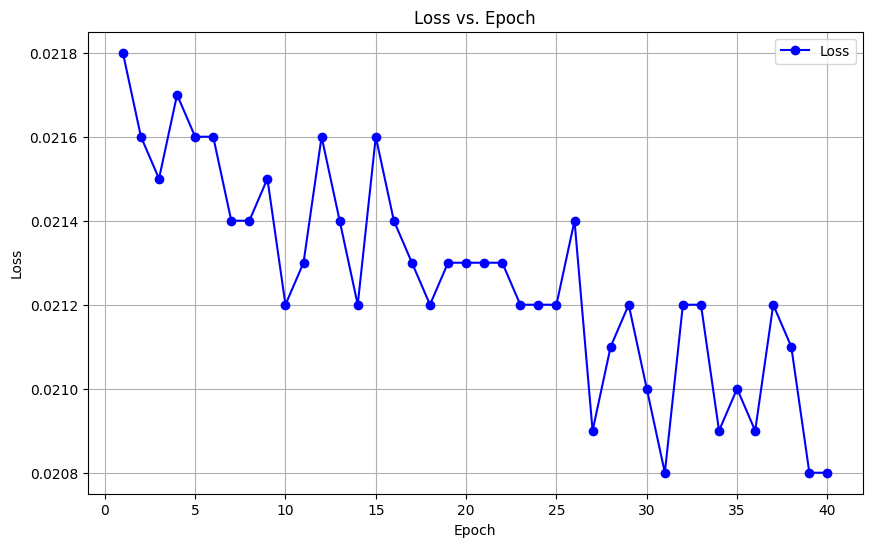

In [ ]:
import matplotlib.pyplot as plt

# List of loss values for each epoch
loss_values = [
    0.0218, 0.0216, 0.0215, 0.0217, 0.0216, 0.0216, 0.0214, 0.0214, 0.0215, 0.0212,
    0.0213, 0.0216, 0.0214, 0.0212, 0.0216, 0.0214, 0.0213, 0.0212, 0.0213, 0.0213,
    0.0213, 0.0213, 0.0212, 0.0212, 0.0212, 0.0214, 0.0209, 0.0211, 0.0212, 0.0210,
    0.0208, 0.0212, 0.0212, 0.0209, 0.0210, 0.0209, 0.0212, 0.0211, 0.0208, 0.0208
]

# List of epoch numbers
epochs = list(range(1, 41))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', color='b', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


Create Samples for inference

In [ ]:
def sample(model, scheduler, train_config, model_config, diffusion_config):
    """
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    sample_shape = (train_config['num_samples'], model_config['im_channels'], model_config['im_size'], model_config['im_size'])
    xt = torch.randn(sample_shape).to(device)

    # Starting backward from noisy image
    for i in tqdm(reversed(range(diffusion_config['num_timesteps'])), desc="Sampling Timesteps"):
        # Get prediction of noise
        noise_pred = model(xt, torch.as_tensor(i).unsqueeze(0).to(device))

        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))

        # Save x0
        ims = torch.clamp(xt, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)


        # Create directories if they don't exist
        samples_dir = os.path.join(train_config['task_name'], 'samples')
        os.makedirs(samples_dir, exist_ok=True)

        img.save(os.path.join(samples_dir, f'x0_{i}.png'))
        img.close()

def inference(config_path = 'config/mnist.yaml'):
    # Read the config file
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
    print(config)

    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']

    # Load model with checkpoint
    model = Unet(model_config).to(device)
    assert os.path.exists(os.path.join(train_config['task_name'],
                                       train_config['ddpm_ckpt_name'])), "Train DDPM first"
    model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                  train_config['ddpm_ckpt_name']), map_location=device))
    model.eval()

    # Create the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])
    with torch.no_grad():
        sample(model, scheduler, train_config, model_config, diffusion_config)



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using mps')

inference(config_path = 'config/mnist.yaml')

{'dataset_params': {'im_path': 'data/mnist/train/images', 'im_test_path': 'data/mnist/test/images', 'canny_im_size': 28}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'im_channels': 1, 'im_size': 28, 'hint_channels': 3, 'down_channels': [32, 64, 128, 256], 'mid_channels': [256, 256, 128], 'down_sample': [True, True, False], 'time_emb_dim': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'num_heads': 4}, 'train_params': {'task_name': 'mnist', 'batch_size': 64, 'num_epochs': 40, 'controlnet_epochs': 1, 'num_samples': 25, 'num_grid_rows': 5, 'ddpm_lr': 0.0001, 'controlnet_lr': 0.0001, 'ddpm_ckpt_name': 'ddpm_ckpt.pth', 'controlnet_ckpt_name': 'ddpm_controlnet_ckpt.pth'}}


Sampling Timesteps: 1000it [14:38,  1.14it/s]


In [ ]:
# Move to project directory
%cd /content/drive/MyDrive/ControlNet-PyTorch


def plot_samples(samples_dir, interval, max_samples, config_path='config/mnist.yaml'):
    """
    Plot MNIST images from the specified directory with annotations.

    Parameters:
    samples_dir (str): Directory containing the sample images.
    interval (int): The interval at which to plot the images (e.g., every 200 samples).
    max_samples (int): The maximum number of samples to plot.
    """
    # Load num_timesteps from config file
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
            return  # Exit if config loading fails

    plt.figure(figsize=(20, 15))  # Set the figure size
    count = 0  # Initialize a counter for plotting
    for i in range(0, config['diffusion_params']['num_timesteps'], interval):
        img_path = os.path.join(samples_dir, f'x0_{i}.png')  # Create the path for the image
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(5, 5, count + 1)
            plt.imshow(img)  # Display the image in grayscale
            plt.axis('off')  # Hide the axes

            # Add annotation for the sample number
            plt.text(0.5, -0.1, f'Iteration: {i}', fontsize=12, ha='center', transform=plt.gca().transAxes)
            count += 1
        else:
            print(f"Image {img_path} does not exist.")

    plt.suptitle(f'Trained MNIST Samples with diffusion model Every {interval} Steps', fontsize=16)
    plt.tight_layout(pad=1)
    plt.subplots_adjust(top=0.95)
    plt.show()

/content/drive/MyDrive/ControlNet-PyTorch


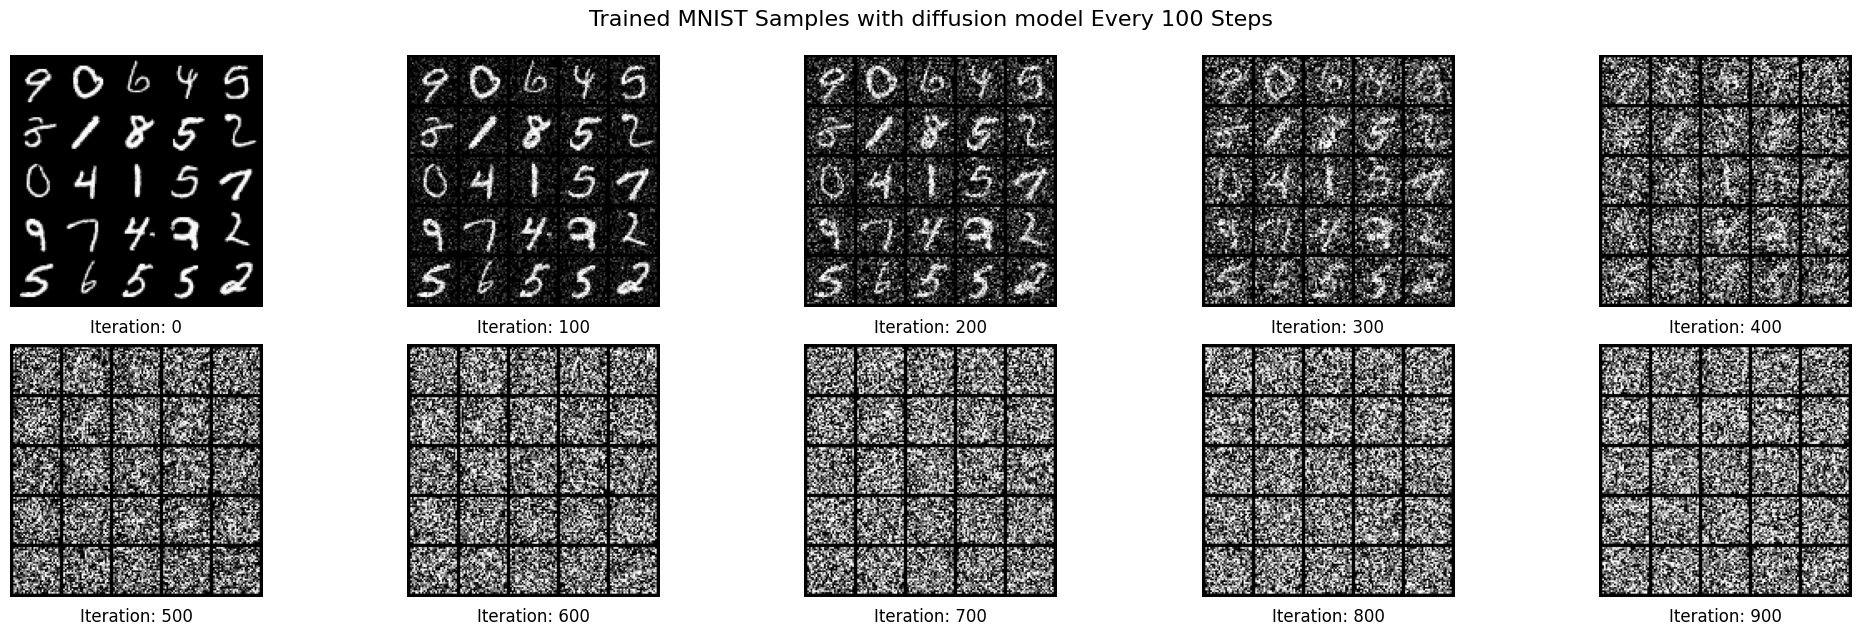

<Figure size 640x480 with 0 Axes>

In [ ]:
reduced_samples_directory = '/content/drive/MyDrive/ControlNet-PyTorch/mnist/samples'
interval = 100
max_samples = 10
plot_samples(reduced_samples_directory, interval, max_samples)
plt.savefig("generated_ddpm.png", format='png', dpi=300, bbox_inches='tight')

# Diffusion Model with ControlNet

In [ ]:
# Function to zero out parameters of a module (freeze it in place)
def make_zero_module(module):
    for p in module.parameters():
        p.detach().zero_()  # Detach gradients and set all weights to zero
    return module

# ControlNet Class Definition
class ControlNet(nn.Module):
    r"""
    ControlNet Module for Diffusion Model Training
    """
    def __init__(self, model_config,
                 model_locked=True,  # Option to lock trained model’s parameters
                 model_ckpt=None,  # Path to the model checkpoint file
                 device=None):  # Device for computation
        super().__init__()

        # Initialize a trained U-Net model
        self.model_locked = model_locked  # Store if model layers are locked
        self.trained_unet = Unet(model_config)  # Create a U-Net instance

        # Load weights into the trained U-Net model if checkpoint and device are provided
        if model_ckpt is not None and device is not None:
            print('Loading Trained Diffusion Model')
            self.trained_unet.load_state_dict(torch.load(model_ckpt,
                                                         map_location=device), strict=True)

        # Create a ControlNet copy of the trained U-Net model
        # with decoder layers removed by setting use_up to False
        self.control_copy_unet = Unet(model_config, use_up=False)

        # Load the same weights into the ControlNet copy
        if model_ckpt is not None and device is not None:
            print('Loading Control Diffusion Model')
            self.control_copy_unet.load_state_dict(torch.load(model_ckpt,
                                                              map_location=device), strict=False)

        # Define the Hint Block, which consists of several convolutional layers
        # and a zeroed-out convolution at the end
        self.control_copy_unet_hint_block = nn.Sequential(
            nn.Conv2d(model_config['hint_channels'],
                      64,
                      kernel_size=3,
                      padding=(1, 1)),  # Convolution layer
            nn.SiLU(),  # Activation function
            nn.Conv2d(64,
                      128,
                      kernel_size=3,
                      padding=(1, 1)),  # Convolution layer
            nn.SiLU(),  # Activation function
            nn.Conv2d(128,
                      self.trained_unet.down_channels[0],
                      kernel_size=3,
                      padding=(1, 1)),  # Convolution layer
            nn.SiLU(),  # Activation function
            make_zero_module(nn.Conv2d(self.trained_unet.down_channels[0],
                                       self.trained_unet.down_channels[0],
                                       kernel_size=1, padding = 0))  # Zeroed-out convolution
        )

        # Zero Convolution Modules for the encoder (down blocks)
        self.control_copy_unet_down_zero_convs = nn.ModuleList([
            make_zero_module(nn.Conv2d(self.trained_unet.down_channels[i],
                                       self.trained_unet.down_channels[i],
                                       kernel_size=1,
                                       padding=0))  # Zero convolution
            for i in range(len(self.trained_unet.down_channels)-1)  # Exclude last layer
        ])

        # Zero Convolution Modules for the mid blocks
        self.control_copy_unet_mid_zero_convs = nn.ModuleList([
            make_zero_module(nn.Conv2d(self.trained_unet.mid_channels[i],
                                       self.trained_unet.mid_channels[i],
                                       kernel_size=1,
                                       padding=0))  # Zero convolution
            for i in range(1, len(self.trained_unet.mid_channels))  # Start from second layer
        ])

    # Function to retrieve parameters for optimization
    def get_params(self):
        # Gather all ControlNet parameters, starting with the U-Net copy
        params = list(self.control_copy_unet.parameters())

        # Add parameters from hint block and zero convolutions
        params += list(self.control_copy_unet_hint_block.parameters())
        params += list(self.control_copy_unet_down_zero_convs.parameters())
        params += list(self.control_copy_unet_mid_zero_convs.parameters())

        # If model isn’t locked, add decoder (upsampling) parameters
        if not self.model_locked:
            params += list(self.trained_unet.ups.parameters())
            params += list(self.trained_unet.norm_out.parameters())
            params += list(self.trained_unet.conv_out.parameters())
        return params  # Return the collected parameters

    # Forward pass through the ControlNet model
    def forward(self, x, t, hint):
        # Embed the time step and project for trained U-Net
        trained_unet_t_emb = get_time_embedding(torch.as_tensor(t).long(),
                                                self.trained_unet.t_emb_dim)
        trained_unet_t_emb = self.trained_unet.t_proj(trained_unet_t_emb)

        # Collect outputs of downblocks from the trained U-Net
        trained_unet_down_outs = []
        with torch.no_grad():  # Freeze trained U-Net
            train_unet_out = self.trained_unet.conv_in(x)
            for down in self.trained_unet.downs:
                trained_unet_down_outs.append(train_unet_out)  # Save each down output
                train_unet_out = down(train_unet_out, trained_unet_t_emb)

        # Process ControlNet U-Net with time embedding and hint block
        control_copy_unet_t_emb = get_time_embedding(torch.as_tensor(t).long(),
                                                     self.control_copy_unet.t_emb_dim)
        control_copy_unet_t_emb = self.control_copy_unet.t_proj(control_copy_unet_t_emb)

        # Pass hint input through the hint block
        control_copy_unet_hint_out = self.control_copy_unet_hint_block(hint)

        # Pass input through the initial conv layer of ControlNet U-Net
        control_copy_unet_out = self.control_copy_unet.conv_in(x)
        control_copy_unet_out += control_copy_unet_hint_out  # Add hint output

        # Collect downblock outputs for ControlNet
        control_copy_unet_down_outs = []
        for idx, down in enumerate(self.control_copy_unet.downs):
            # Zero conv output appended before down layer
            control_copy_unet_down_outs.append(
                self.control_copy_unet_down_zero_convs[idx](control_copy_unet_out)
            )
            control_copy_unet_out = down(control_copy_unet_out, control_copy_unet_t_emb)

        # Pass through the midblocks of ControlNet and trained U-Net
        for idx in range(len(self.control_copy_unet.mids)):
            control_copy_unet_out = self.control_copy_unet.mids[idx](
                control_copy_unet_out,
                control_copy_unet_t_emb
            )

            train_unet_out = self.trained_unet.mids[idx](train_unet_out, trained_unet_t_emb)

            # Combine ControlNet and trained U-Net mid outputs through zero convs
            train_unet_out += self.control_copy_unet_mid_zero_convs[idx](control_copy_unet_out)

        # Process through upblocks of the trained U-Net model
        for up in self.trained_unet.ups:
            # Pop downblock outputs and combine them
            trained_unet_down_out = trained_unet_down_outs.pop()
            control_copy_unet_down_out = control_copy_unet_down_outs.pop()
            train_unet_out = up(train_unet_out,
                                control_copy_unet_down_out + trained_unet_down_out,
                                trained_unet_t_emb)

        # Final output layer processing
        train_unet_out = self.trained_unet.norm_out(train_unet_out)
        train_unet_out = nn.SiLU()(train_unet_out)  # Activation function
        train_unet_out = self.trained_unet.conv_out(train_unet_out)  # Convolution layer
        return train_unet_out  # Output in B x C x H x W format


Train DDPM-ControlNet

In [ ]:
# reduced_dataset_cnet = 1000

# Define the main training function
def train(config_path='config/mnist.yaml', device='mps', training_small_dataset=False):
    # Load the configuration file
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
    print(config)  # Display the loaded configuration

    # Extract configurations for different components
    diffusion_config = config['diffusion_params']
    dataset_config = config['dataset_params']
    model_config = config['model_params']
    train_config = config['train_params']

    # Initialize the noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])

    # Set up the dataset and data loader
    mnist = MnistDataset('train',  # Specify training data
                         im_path=dataset_config['im_path'],  # Path to images
                         return_hints=True)  # Return hint labels
    print(f'MNIST Dataset Size: {len(mnist)}')

    # If testing with a larger dataset, use a subset of it initially,
    if training_small_dataset:
        mnist = torch.utils.data.Subset(mnist, list(range(reduced_dataset_cnet)))
        print(f'Reduced MNIST Dataset Size: {len(mnist)}')

    mnist_loader = DataLoader(mnist, batch_size=train_config['batch_size'], shuffle=True)

    # Initialize the model and load a checkpoint if available
    model = ControlNet(model_config,
                       model_locked=True,  # Use model in locked mode
                       model_ckpt=os.path.join(train_config['task_name'],
                                               train_config['ddpm_ckpt_name']),
                       device=device).to(device)

    model.train()  # Set model to training mode

    # Create directory to save training outputs if it doesn't exist
    if not os.path.exists(train_config['task_name']):
        os.mkdir(train_config['task_name'])

    # Load a previous checkpoint if available
    if os.path.exists(os.path.join(train_config['task_name'],
                                   train_config['controlnet_ckpt_name'])):
        print('Loading checkpoint as one was found')
        model.load_state_dict(torch.load(os.path.join(train_config['task_name'],
                                                      train_config['controlnet_ckpt_name']),
                                         map_location=device))

    # Set up training parameters
    num_epochs = train_config['controlnet_epochs']  # Number of training epochs
    optimizer = Adam(model.get_params(), lr=train_config['controlnet_lr'])  # Optimizer with learning rate
    criterion = torch.nn.MSELoss()  # Loss function to minimize

    # Run the training loop
    steps = 0  # Step counter
    for epoch_idx in range(num_epochs):  # Iterate over epochs
        losses = []  # Track losses for each epoch
        for im, hint in tqdm(mnist_loader):  # Load batch of images and hints
            optimizer.zero_grad()  # Reset gradients

            # Move data to the correct device and ensure it's in float format
            im = im.float().to(device)
            hint = hint.float().to(device)

            # Generate random noise and sample timesteps
            noise = torch.randn_like(im).to(device)  # Create random noise
            t = torch.randint(0, diffusion_config['num_timesteps'], (im.shape[0],)).to(device)  # Random timesteps

            # Add noise to images based on the timestep
            noisy_im = scheduler.add_noise(im, noise, t)

            # Predict noise using model, then compute and backpropagate the loss
            noise_pred = model(noisy_im, t, hint)
            loss = criterion(noise_pred, noise)  # Compare prediction with actual noise
            losses.append(loss.item())  # Track the loss
            loss.backward()  # Backpropagate loss
            optimizer.step()  # Update model weights
            steps += 1  # Increment step counter

        # Display progress at the end of each epoch
        print(f'Finished epoch: {epoch_idx + 1} | Loss: {np.mean(losses):.4f}')

        # Save model state after each epoch
        torch.save(model.state_dict(), os.path.join(train_config['task_name'],
                                                    train_config['controlnet_ckpt_name']))

    print(f'Done training!')

In [ ]:
# Move to project directory
%cd /content/drive/MyDrive/ControlNet-PyTorch

# Main execution
mnist_train_config = 'config/mnist.yaml'

# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS')


print(f'Start training!')

# Call the function to train on the dataset
train(mnist_train_config, device, training_small_dataset= False) # For full dataset

/content/drive/MyDrive/ControlNet-PyTorch
Start training!
{'dataset_params': {'im_path': 'data/mnist/train/images', 'im_test_path': 'data/mnist/test/images', 'canny_im_size': 28}, 'diffusion_params': {'num_timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02}, 'model_params': {'im_channels': 1, 'im_size': 28, 'hint_channels': 3, 'down_channels': [32, 64, 128, 256], 'mid_channels': [256, 256, 128], 'down_sample': [True, True, False], 'time_emb_dim': 128, 'num_down_layers': 2, 'num_mid_layers': 2, 'num_up_layers': 2, 'num_heads': 4}, 'train_params': {'task_name': 'mnist', 'batch_size': 64, 'num_epochs': 40, 'controlnet_epochs': 1, 'num_samples': 25, 'num_grid_rows': 5, 'ddpm_lr': 0.0001, 'controlnet_lr': 0.0001, 'ddpm_ckpt_name': 'ddpm_ckpt.pth', 'controlnet_ckpt_name': 'ddpm_controlnet_ckpt.pth'}}


100%|██████████| 10/10 [00:52<00:00,  5.26s/it]


Found 60000 images for split "train"
MNIST Dataset Size: 60000
Loading Trained Diffusion Model
Loading Control Diffusion Model
Loading checkpoint as one was found


100%|██████████| 938/938 [5:20:49<00:00, 20.52s/it]


Finished epoch: 1 | Loss: 0.0271
Done training!


Create Sampling from ControlNet

In [ ]:
def generate_samples(model, scheduler, train_cfg, model_cfg, diff_cfg, dataset):
    """
    Generate samples by iteratively going backwards through time steps.
    Stores intermediate x0 predictions.
    """
    # Initialize with random noise
    xt = torch.randn((train_cfg['num_samples'],
                       model_cfg['im_channels'],
                       model_cfg['im_size'],
                       model_cfg['im_size'])).to(device)

    # Randomly select hints from the dataset
    hints = torch.cat([dataset[random.randint(0, len(dataset) - 1)][1].unsqueeze(0).to(device)
                       for _ in range(train_cfg['num_samples'])], dim=0).to(device)

    # Save hint images
    hint_image_grid = make_grid(hints, nrow=train_cfg['num_grid_rows'])
    hint_image = torchvision.transforms.ToPILImage()(hint_image_grid)
    hint_image.save(os.path.join(train_cfg['task_name'], 'hint.png'))

    # Reverse diffusion process
    for t in tqdm(reversed(range(diff_cfg['num_timesteps']))):
        # Predict noise for current step
        noise_pred = model(xt, torch.tensor([t], device=device), hints)

        # Calculate x0 and previous xt with scheduler
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))

        # Save predicted x0 images
        normalized_imgs = (torch.clamp(xt, -1, 1) + 1) / 2
        sample_grid = make_grid(normalized_imgs.cpu(), nrow=train_cfg['num_grid_rows'])
        sample_image = torchvision.transforms.ToPILImage()(sample_grid)

        save_dir = os.path.join(train_cfg['task_name'], 'samples_controlnet')
        os.makedirs(save_dir, exist_ok=True)
        sample_image.save(os.path.join(save_dir, f'x0_{t}.png'))
        sample_image.close()


def run_inference(config_path ='config/mnist.yaml'):
    # Load configuration
    with open(config_path, 'r') as f:
        try:
            config = yaml.safe_load(f)
        except yaml.YAMLError as e:
            print("Error loading configuration file:", e)
            return

    # Extract configurations
    diffusion_config = config['diffusion_params']
    model_config = config['model_params']
    train_config = config['train_params']
    dataset_config = config['dataset_params']

    # Load dataset with hint annotations
    mnist_canny_dataset = MnistDataset('test', im_path=dataset_config['im_test_path'], return_hints=True)

    # Initialize model with ControlNet checkpoint
    model = ControlNet(model_config,
                       model_ckpt=os.path.join(train_config['task_name'],
                       train_config['ddpm_ckpt_name']),
                       device=device).to(device)

    # Ensure ControlNet checkpoint exists before loading
    controlnet_ckpt_path = os.path.join(train_config['task_name'], train_config['controlnet_ckpt_name'])

    assert os.path.exists(controlnet_ckpt_path), "ControlNet checkpoint not found. Train the model first."
    model.load_state_dict(torch.load(controlnet_ckpt_path, map_location=device))
    model.eval()
    print('ControlNet checkpoint loaded successfully.')

    # Set up noise scheduler
    scheduler = LinearNoiseScheduler(num_timesteps=diffusion_config['num_timesteps'],
                                     beta_start=diffusion_config['beta_start'],
                                     beta_end=diffusion_config['beta_end'])

    # Generate samples with no gradient computation
    with torch.no_grad():
        generate_samples(model, scheduler, train_config, model_config, diffusion_config, mnist_canny_dataset)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using mps')

%cd /content/drive/MyDrive/ControlNet-PyTorch
run_inference(config_path ='config/mnist.yaml')

/content/drive/MyDrive/ControlNet-PyTorch


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
<ipython-input-6-b8d272b53ed8>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.trained_unet.load_state_dict(torch.load

Found 10000 images for split "test"
Loading Trained Diffusion Model
Loading Control Diffusion Model


<ipython-input-6-b8d272b53ed8>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.control_copy_unet.load_state_dict(torch.load(model_ckpt,
<ipython-input-8-544023126f3c>

ControlNet checkpoint loaded successfully.


1000it [03:04,  5.41it/s]


Plot the inferences

In [ ]:
# Move directory
%cd /content/drive/MyDrive/ControlNet-PyTorch


def plot_generated_and_hint_samples(samples_dir, hint_img_path, interval, max_samples, config_path='config/mnist.yaml'):
    """
    Plot generated samples alongside their Canny hint images for comparison.

    Parameters:
    samples_dir (str): Directory containing the generated sample images.
    hint_img_path (str): Path to the Canny hint images file.
    interval (int): Interval at which to plot the generated images.
    max_samples (int): Maximum number of samples to plot.
    """
    # Load num_timesteps from config file
    with open(config_path, 'r') as file:
        try:
            config = yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(f"Error reading the config file: {exc}")
            return  # Exit if config loading fails

    num_timesteps = config['diffusion_params']['num_timesteps']
    plt.figure(figsize=(12, max_samples * 5))  # Set the figure size for a larger display

    # Load the hint images (assumes hints are saved in a single grid image)
    hint_img = Image.open(hint_img_path)

    count = 0  # Initialize counter for plotting
    for step in range(0, num_timesteps, interval):
        gen_img_path = os.path.join(samples_dir, f'x0_{step}.png')  # Path for each generated image
        if os.path.exists(gen_img_path):
            gen_img = Image.open(gen_img_path)

            # Plot the hint and generated images side by side
            plt.subplot(max_samples, 2, count * 2 + 1)
            plt.imshow(hint_img, cmap='gray')
            plt.axis('off')
            plt.title(f'Canny Hint', fontsize=10)

            plt.subplot(max_samples, 2, count * 2 + 2)
            plt.imshow(gen_img, cmap='gray')
            plt.axis('off')
            plt.title(f'Generated Sample at Step {step}', fontsize=10)

            count += 1
        else:
            print(f"Generated image {gen_img_path} does not exist.")

        # Stop plotting if max_samples limit is reached
        if count >= max_samples:
            break

    plt.suptitle(f'Generated Samples vs. Canny Hints Every {interval} Steps', fontsize=16)
    plt.tight_layout(pad=1)
    plt.subplots_adjust(top=0.95)
    plt.show()

/content/drive/MyDrive/ControlNet-PyTorch


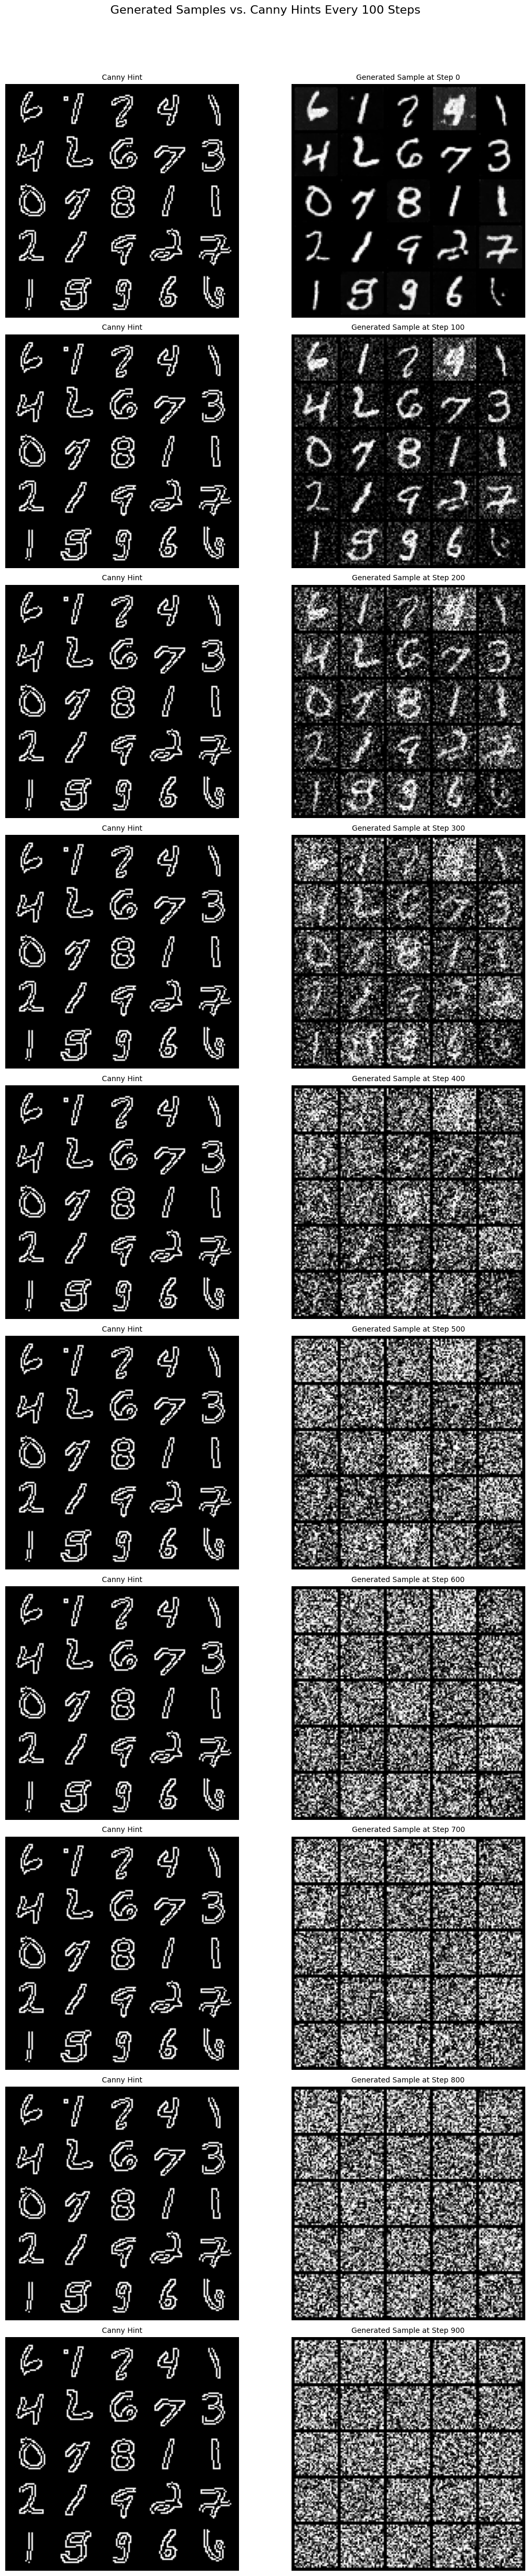

<Figure size 640x480 with 0 Axes>

In [ ]:
generated_samples_directory = '/content/drive/MyDrive/ControlNet-PyTorch/mnist/samples_controlnet'
hint_image_path = '/content/drive/MyDrive/ControlNet-PyTorch/mnist/hint.png'  # Path to saved hint image
interval = 100  # Interval
max_samples = 10  # Number of samples to compare
plot_generated_and_hint_samples(generated_samples_directory, hint_image_path, interval, max_samples)
plt.savefig("generated_vs_canny_comparison.png", format='png', dpi=300, bbox_inches='tight')

In [ ]:
def create_evolution_video(samples_dir, hint_img_path, num_timesteps, output_video_path, fps):
    """
    Create a video showing the evolution of generated samples alongside a Canny edge hint.

    Parameters:
    samples_dir (str): Directory containing the generated sample images.
    hint_img_path (str): Path to the Canny edge hint image.
    num_timesteps (int): Total number of timesteps in the diffusion process.
    output_video_path (str): Output path for the video file.
    fps (int): Frames per second for the video.
    """
    # Load the hint image as grayscale
    hint_img = Image.open(hint_img_path).convert('L')  # Load as grayscale
    hint_img_np = np.array(hint_img)

    # Get the dimensions of the first sample image
    sample_img_path = os.path.join(samples_dir, 'x0_0.png')
    sample_img = Image.open(sample_img_path).convert('L')
    sample_img_np = np.array(sample_img)

    # Combine hint and sample
    frame_height, frame_width = sample_img_np.shape[0], sample_img_np.shape[1] * 2
    video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))


    for t in reversed(range(num_timesteps)):
        sample_img_path = os.path.join(samples_dir, f'x0_{t}.png')
        if os.path.exists(sample_img_path):
            sample_img = Image.open(sample_img_path).convert('L')
            sample_img_np = np.array(sample_img)

            # Concatenate hint and sample images
            combined_frame = np.concatenate((hint_img_np, sample_img_np), axis=1)

            # Add timestep text on top
            combined_frame_bgr = cv2.cvtColor(combined_frame, cv2.COLOR_GRAY2BGR)
            cv2.putText(combined_frame_bgr, f'Timestep: {t}', (10, 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)



            video_writer.write(combined_frame_bgr)
        else:
            print(f"Image {sample_img_path} does not exist.")

    video_writer.release()
    print(f"Video saved to {output_video_path}")

In [ ]:
samples_directory = '/content/drive/MyDrive/ControlNet-PyTorch/mnist/samples_controlnet'
hint_image_path = '/content/drive/MyDrive/ControlNet-PyTorch/mnist/hint.png'
output_video_path = '/content/drive/MyDrive/ControlNet-PyTorch/mnist/samples_controlnet/evolution_video.mp4'
fps = 20  # Frames per second for the video
num_timesteps = 1000
# Create the video
create_evolution_video(samples_directory, hint_image_path, num_timesteps, output_video_path, fps)

Video saved to /content/drive/MyDrive/ControlNet-PyTorch/mnist/samples_controlnet/evolution_video.mp4
